In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from evaluation import *
from time import time
import json
from tqdm import tqdm
import seaborn as sns
from utils import *

In [25]:
img1 = cv2.imread("data/training/image_0/000045_10.png")
img2 = cv2.imread("data/training/image_0/000045_11.png")
gt_flow = cv2.imread(r"data/training/flow_noc/000045_10.png", cv2.IMREAD_UNCHANGED).astype(np.double)
gt_flow = convert_optical_flow_to_image(gt_flow)

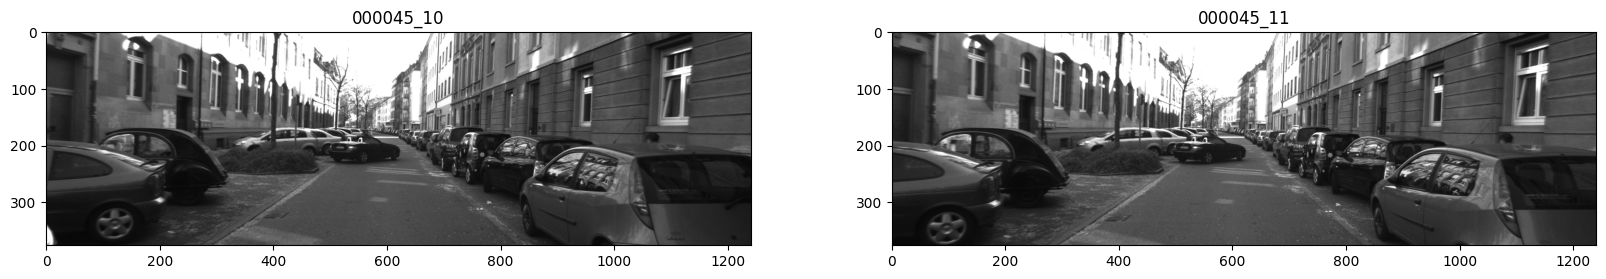

In [26]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[0].set_title("000045_10")
ax[1].set_title("000045_11");

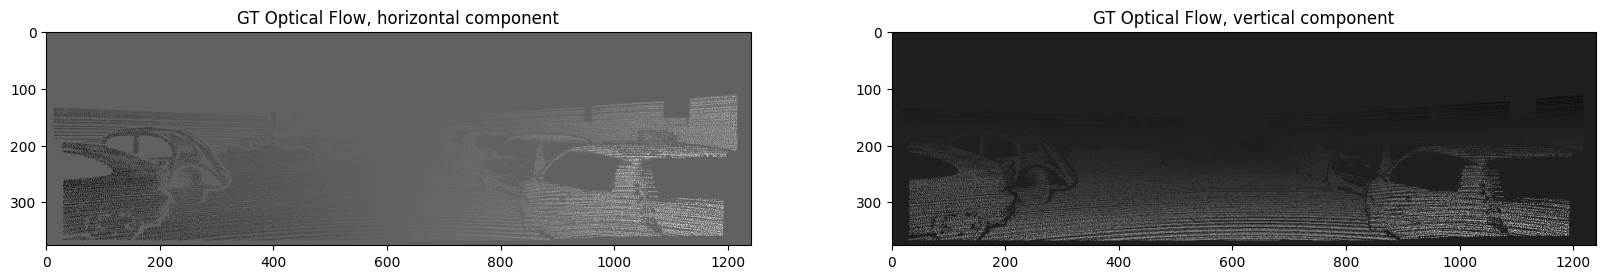

In [27]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
ax[0].imshow(gt_flow[:,:,0], cmap="gray")
ax[1].imshow(gt_flow[:,:,1], cmap="gray")
ax[0].set_title("GT Optical Flow, horizontal component")
ax[1].set_title("GT Optical Flow, vertical component");

In [28]:
def BM_Optical_Flow(img1, img2, block_size, search_area, step_size, error_function):
    """
        Optical flow estimation using the block matching algorithm.
        Args:
            img1/img2: Images of size (W, H) to compute the optical flow map on.
            block_size: Size of the block divisions.
            search area: Area around a reference block to look for movement.
            step size: Step size used during the extensive search step.
            error_function: Name of the error function used to compare blocks.
                Has to be "euclidian", "ssim" or "hist_intersection.
        Returns:
            Optical flow map (np.array): Array with shape (W, H, 2), where the 
                third dimension corresponds to the horizontal and vertical components
                of the optical flow estimation.
    """
    # Original image size
    Ho, Wo, _ = img1.shape

    # Resize images until they have dimensions multiple of the patch size
    num_hor_blocks = (Wo//block_size)
    num_ver_blocks = (Ho//block_size)
    img1_r = cv2.resize(img1, (num_hor_blocks*block_size, num_ver_blocks*block_size))
    img1_r = cv2.cvtColor(img1_r, cv2.COLOR_BGR2GRAY)
    img2_r = cv2.resize(img2, (num_hor_blocks*block_size, num_ver_blocks*block_size))
    img2_r = cv2.cvtColor(img2_r, cv2.COLOR_BGR2GRAY)
    H, W = img1_r.shape

    # Divide image 1 into equally-sized blocks
    block_matrix = img1_r.reshape((-1, block_size, img1_r.shape[1]//block_size, block_size))  
    block_matrix = block_matrix.transpose((0,2,1,3))

    optical_flow_map = np.zeros((H, W, 2))
    for block_col in range(num_hor_blocks):
        for block_row in range(num_ver_blocks):
            #print(f"({block_col*num_ver_blocks + block_row + 1}/{num_hor_blocks*num_ver_blocks}) Current patch: ({block_col}, {block_row}) ", end="\r")
            # Current Image 1 block
            block_a = block_matrix[block_row,  block_col]

            # Search space logic
            a = max(block_col*block_size-search_area, 0)
            b = min(block_col*block_size+search_area, W-block_size)
            c = max(block_row*block_size-search_area, 0)
            d = min(block_row*block_size+search_area, H-block_size)

            best_pos, best_dist = None, np.inf
            for k in range(c, d, step_size):
                for l in range(a, b, step_size):
                    block_b = img2_r[k:(k+block_size), l:(l+block_size)]
                    if error_function == "euclidean":
                        dist = euclidian_distance(block_a.flatten(), block_b.flatten())
                    elif error_function == "hist_intersection":
                        block_a_hist = cv2.calcHist(block_a, channels=[0], mask=None, histSize=[256], ranges=[0,256])
                        block_b_hist = cv2.calcHist(block_b, channels=[0], mask=None, histSize=[256], ranges=[0,256])
                        dist = -1*histogram_intersection(block_a_hist, block_b_hist)
                    elif error_function == "ssim":
                        dist = -1*ssim(block_a, block_b, data_range=256)
                    if dist < best_dist:
                        best_pos = (l, k)
                        best_dist = dist

            pt1 = np.array((block_col*block_size, block_row*block_size))
            pt2 = np.array((best_pos[0], best_pos[1]))
            
            optical_flow_map[pt1[1]:(pt1[1]+block_size), pt1[0]:(pt1[0]+block_size), 0] = np.linalg.norm(pt1[0] - pt2[0])
            optical_flow_map[pt1[1]:(pt1[1]+block_size), pt1[0]:(pt1[0]+block_size), 1] = np.linalg.norm(pt1[1] - pt2[1])

    # Resize optical flow map to the original size of the images
    return cv2.resize(optical_flow_map, (Wo, Ho))

In [1]:
# Define parameters to perform the grid-search hyperparameter optimization
params_dict = {
    "block_size": [3, 5, 7, 9, 15, 31, 51],
    "search_area": [5, 10, 25, 50],
    "step_size": [2, 5, 10],
    "error_function": ["euclidean", "hist_intersection", "ssim"]
}

In [ ]:
results = []
trial_id = 0
for params in tqdm(makeGrid(params_dict)):
    if params["step_size"] > params["block_size"]:
        # Ensure step size is bigger than the block size
        continue
    if params["error_function"] == "ssim" and params["block_size"] in [3, 5]:
        # Prevent SSIM from raising a win_size error (blocks should be atleast 7x7)
        continue
    # Run optical flow computation (log execution time)
    start = time()
    optical_flow_map = BM_Optical_Flow(img1=img1, img2=img2, **params)
    end = time()

    # Get metrics
    msen, sen = MSEN(gt_flow, optical_flow_map, f"./results/bm_gridsearch/trial_{trial_id}")
    pepn = PEPN(sen)

    params["trial_id"] = trial_id
    params["MSEN"] = msen
    params["PEPN"] = pepn
    params["time"] = end - start
    results.append(params)
    trial_id += 1

    with open("./results/bm_gridsearch/results.json", "w") as f:
        json.dump(results, f)

In [30]:
with open("./results/bm_gridsearch/results.json", "r") as f:
    results = json.load(f)

In [ ]:
# Sort results by MSEN
sorted_results = sorted(results, key=lambda d: d['MSEN'])

In [ ]:
# Run best configuration
params = sorted_results[0]
optical_flow_map = BM_Optical_Flow(
    img1=img1, 
    img2=img2,
    block_size=params["block_size"], 
    search_area=params["search_area"], 
    step_size=params["step_size"], 
    error_function=params["error_function"])

(11.164691870037885, 85.1605482603278)

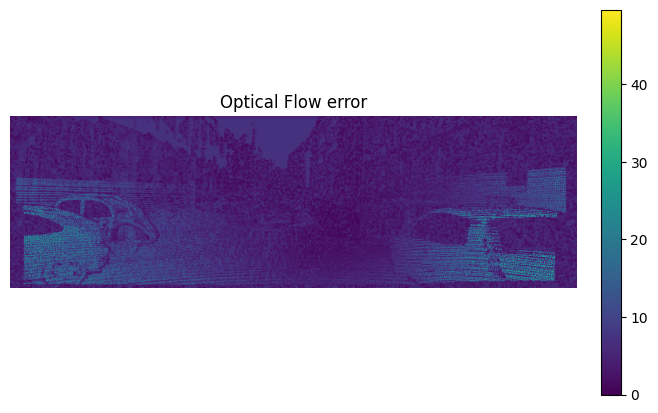

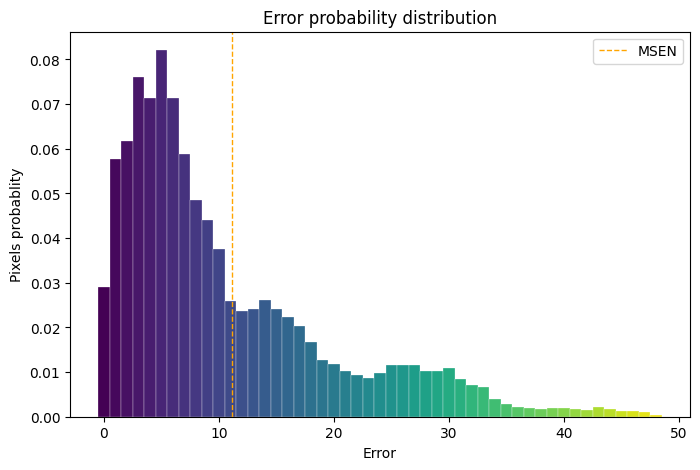

In [46]:
pred_flow = np.dstack((optical_flow_map, np.ones_like(optical_flow_map[:,:,0])))
compute_errors(pred_flow, gt_flow, 3, f"./results/bm_gridsearch/", plots=True)

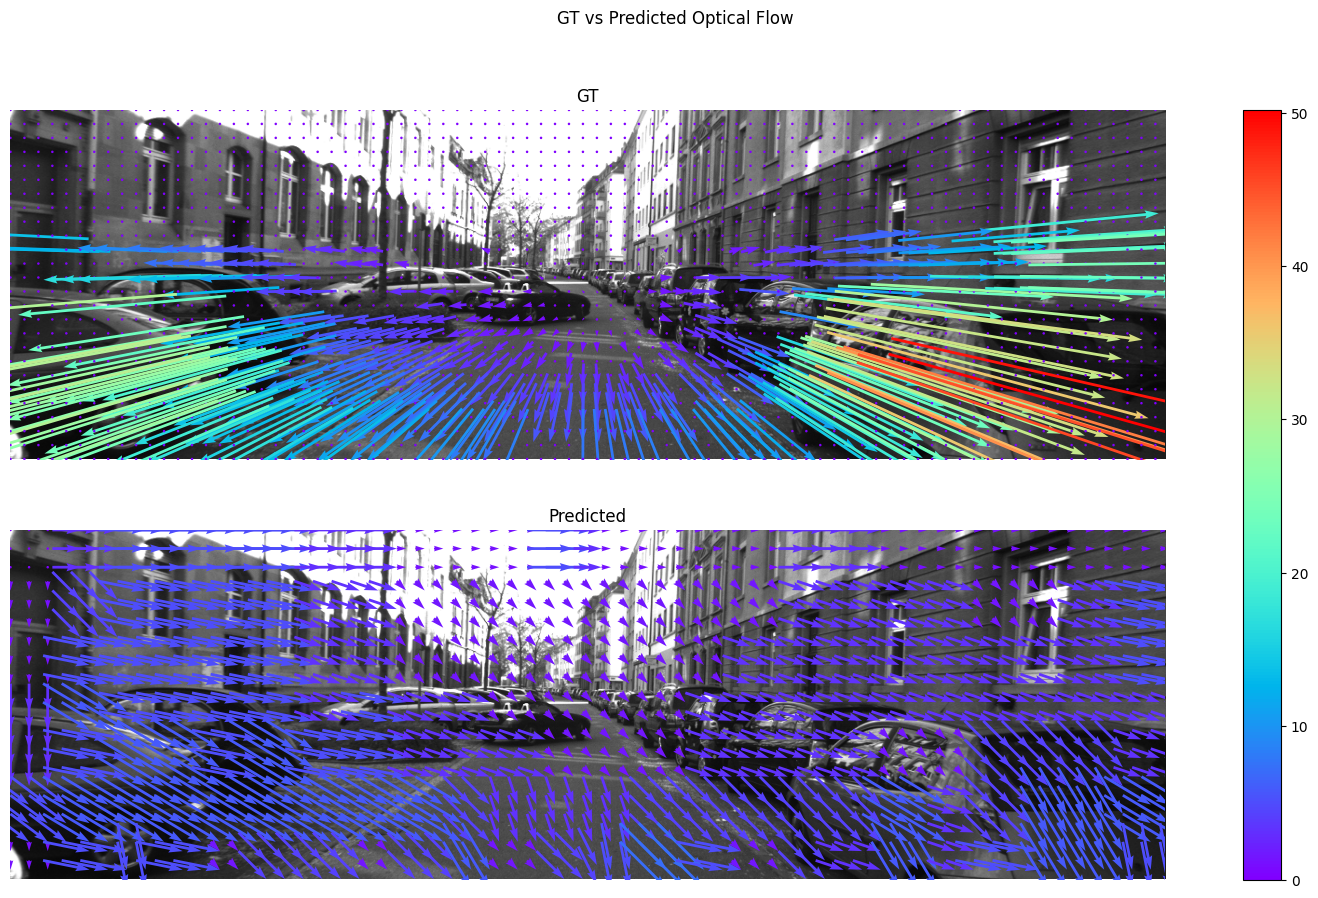

In [35]:
opticalFlow_arrows(img1, gt_flow, pred_flow, 'results/bm_gridsearch/', 'block_matching')